# Amazon Beauty & Personal Care Reviews – Sentiment Classification

**Course:** CSE 158

**Dataset:** Amazon Reviews 2023 – *Beauty and Personal Care*  

# 1. Introduction

This project focuses on sentiment classification for Amazon Beauty & Personal Care reviews. 
Each review comes with free-form text and a 1–5 star rating. We convert this into a binary label:

- **Positive**: rating ≥ 4  
- **Negative**: rating ≤ 3  

The key challenge is that the dataset is **highly imbalanced** (≈75% positive), which makes simple 
accuracy misleading. The goal is therefore to build and compare several text-based models that 
can correctly identify the minority (negative) class.

We evaluate all models on held-out validation and test splits and compare them using accuracy, 
precision, recall, F1, AUC, and confusion matrices.

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib transformers 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler,
)


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report,   
)

from sklearn.pipeline import Pipeline
from collections import Counter


RANDOM_STATE = 42
plt.style.use("default")


In [ ]:
df = pd.read_csv("df_ready.csv")
print(df.head())
print("\nShape:", df.shape)

                                                                                                                                                                                                      text  \
0  this product is great for the skin.  i have dryness on my legs and within a day or two my legs were smooth as can be.  i use it right after a shower.  i also really like that it comes with a pump ...   
1                                                                                                                     this worked after the first night my feet are so smooth i would highly recommend it!   
2                                                                                      i really liked this body wash.  it has a nice smell and thickness and washes off your body easily.  will buy again.   
3  i love this shampoo and conditioner (i have purchased both). first, i love the scent. lightly peppermint and lavender, it fills my shower with the most amazing calming fragr

## 1. Dataset Summary

We use the **Beauty and Personal Care** subset of the Amazon Reviews 2023 dataset.  
From the full 23.9M reviews, we sampled approximately 1% and cleaned it to obtain `df_ready.csv`.

Each row contains:
- `text`: the review text
- `title`: review title
- `rating`: original star rating (1–5)
- `user_id`: reviewer ID
- `asin`: product ID
- `label`: binary sentiment label  
  - `1` = positive (rating ≥ 4)  
  - `0` = negative (rating ≤ 3)

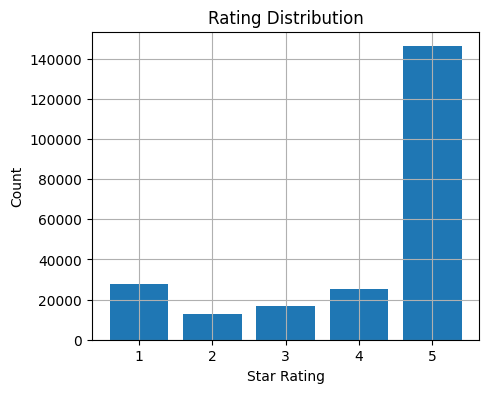

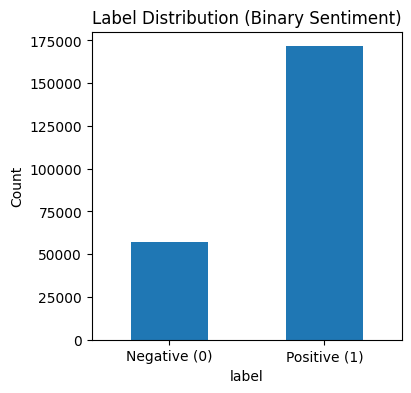

label
0    0.249706
1    0.750294
Name: count, dtype: float64

In [ ]:
if "rating" in df.columns:
    plt.figure(figsize=(5,4))
    df["rating"].hist(bins=[1,2,3,4,5,6], align="left", rwidth=0.8)
    plt.xlabel("Star Rating")
    plt.ylabel("Count")
    plt.title("Rating Distribution")
    plt.show()

plt.figure(figsize=(4,4))
label_counts = df["label"].value_counts().sort_index()
label_counts.plot(kind="bar")
plt.xticks([0,1], ["Negative (0)", "Positive (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Label Distribution (Binary Sentiment)")
plt.show()

label_counts / label_counts.sum()

### Interpretation

The rating distribution is heavily skewed toward 5-star reviews, which is expected for Amazon 
products. After converting ratings to a binary label, roughly **75% of reviews are positive**. 
This imbalance helps explain why a majority-class baseline already achieves ~75% accuracy. 
Because of this, metrics like F1 and recall for the negative class are especially important.


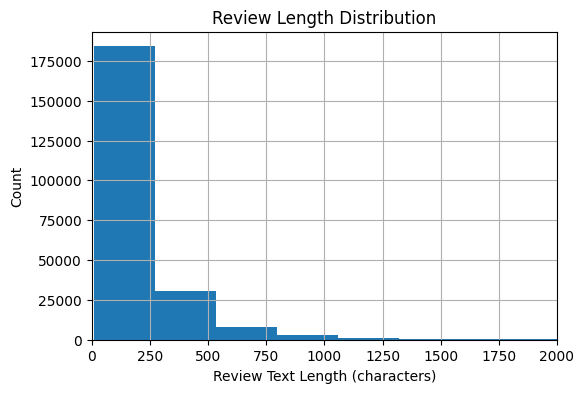

count    228581.000000
mean        186.039093
std         246.570572
min          11.000000
25%          52.000000
50%         114.000000
75%         227.000000
max       13098.000000
Name: text_len, dtype: float64

In [ ]:
df["text_len"] = df["text"].str.len()

plt.figure(figsize=(6,4))
df["text_len"].hist(bins=50)
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Review Length Distribution")
plt.xlim(0, 2000)
plt.show()

df["text_len"].describe()


Most reviews fall between 50 and 250 characters. The long tail of very long reviews means 
that TF-IDF will probably make a high-dimensional sparse matrix, but Logistic Regression and Linear SVM 
can solve this.


## 2. Sample Reviews
Below are a few example reviews from the dataset.


In [ ]:
pd.set_option("display.max_colwidth", 200)
df[["title","rating", "label", "text"]].sample(5, random_state=100)

,title,rating,label,text
36251,it us very expensive but people do not stop complimenting the light fragrance. it lasts for hours.,5.0,1,the value is great but i had to think long and hard about buying it because of budget restraints.
53484,five stars,5.0,1,love the scrub.
157429,four stars,4.0,1,does the best job out of any i've purchased for my husband. would recommend.
25495,five stars,5.0,1,works great have bought multiple now.
92681,great color,5.0,1,i’ve been using this color for years. my hair is light brown with blonde highlights. it’s the only pencil color that’s worked for me.


In [ ]:
def tokenize(s):
    return s.split()

sample_texts = df["text"].sample(20000, random_state=42)
counter = Counter()

for t in sample_texts:
    counter.update(tokenize(t))

most_common = counter.most_common(20)
most_common


[('the', 26646),
 ('i', 26074),
 ('and', 21667),
 ('it', 18476),
 ('a', 16386),
 ('to', 15749),
 ('my', 12543),
 ('this', 12506),
 ('is', 10535),
 ('for', 9488),
 ('of', 7800),
 ('but', 6117),
 ('in', 5946),
 ('not', 5772),
 ('on', 5530),
 ('have', 5367),
 ('with', 5275),
 ('that', 5155),
 ('was', 5133),
 ('so', 4848)]

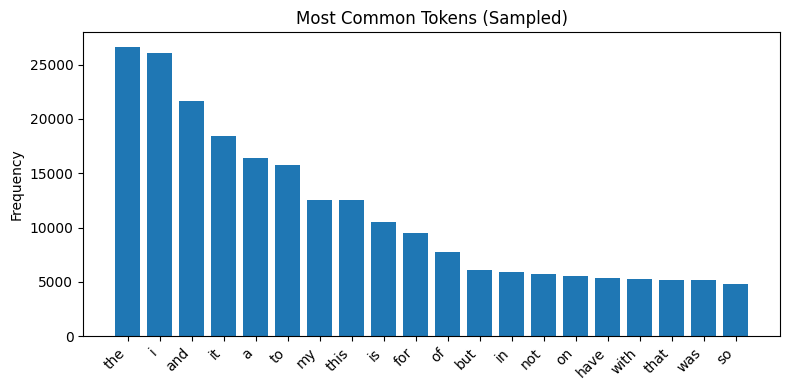

In [ ]:
words, counts = zip(*most_common)
plt.figure(figsize=(8,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Most Common Tokens (Sampled)")
plt.tight_layout()
plt.show()


The  most frequent tokens are stopwords and function words. This means that TF-IDF is a great fit, which pputs less emphasis on these types of words andgives more weight to the meaningful word 
patterns. We expect that sentiment-bearing bigrams (e.g., highly recommend, very disappointed) 
will be useful later.


## 3. Predictive Task



**Goal:**  
Given the text of a review, predict whether the underlying rating is **positive (≥4 stars)** or **negative (≤3 stars)**.

**Input features:**
- `text` (main feature, free-form review text)
- Optionally, `title` can be concatenated to `text` (not strictly necessary)

**Target:**
- `label either 0 or 1`  
  - `0`: negative review  
  - `1`: positive review

This is a **binary classification** problem. We evaluate models using:

- Accuracy  
- Precision, Recall, F1  
- ROC–AUC  
- Confusion matrix


In [90]:
X = df["text"].astype(str).values
y = df["label"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
)

print("Train size:", len(X_train))
print("Valid size:", len(X_valid))
print("Test size: ", len(X_test))


Train size: 182866
Valid size: 22856
Test size:  22859


### 3.1 Classical Models: TF-IDF + Logistic Regression Variants

To understand how different feature scopes and regularization types affect performance, 
we trained four Logistic Regression models:

- **Unigrams + L2**  
- **Unigrams + L1**  
- **Unigrams + Bigrams + L2**  
- **Unigrams + Bigrams + L1**

Bigram features allow the model to capture short sentiment phrases, while L1 encourages sparsity 
and L2 encourages more distributed weights. All models use class weighting to compensate for the 
label imbalance.


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

print("Training TF-IDF + Logistic Regression...")

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.9
    )),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=2000
    ))
])

clf.fit(X_train, y_train)

# Make predictions so confusion matrices and ROC can run
y_valid_pred = clf.predict(X_valid)
y_valid_proba = clf.predict_proba(X_valid)[:, 1]

y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("Done training Logistic Regression.")

Training TF-IDF + Logistic Regression...
Done training Logistic Regression.


In [30]:
def build_logreg_models():
    #Four TF-IDF + Logistic Regression baselines:

    #- tfidf_uni_l2: unigrams, L2 penalty
    #- tfidf_uni_l1: unigrams, L1 penalty
    #- tfidf_uni_bi_l2: uni+bi-grams, L2 penalty
    #- tfidf_uni_bi_l1: uni+bi-grams, L1 penalty
    models = {}
    
    # 1. TF-IDF (unigrams) + L2
    models["tfidf_uni_l2"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 1),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l2",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 2. TF-IDF (unigrams) + L1
    models["tfidf_uni_l1"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 1),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 3. TF-IDF (uni+bi) + L2
    models["tfidf_uni_bi_l2"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 2),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l2",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    # 4. TF-IDF (uni+bi) + L1
    models["tfidf_uni_bi_l1"] = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 2),
                    min_df=5,
                    max_df=0.95,
                ),
            ),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    solver="liblinear",
                    max_iter=1000,
                    class_weight="balanced",
                ),
            ),
        ]
    )

    return models


def evaluate_split(split_name, y_true, y_pred, y_scores=None):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    print(f"\n[{split_name}]")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")

    if y_scores is not None:
        try:
            roc = roc_auc_score(y_true, y_scores)
            print(f"ROC-AUC  : {roc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (only one class).")


logreg_models = build_logreg_models()

extra_results = [] 

for name, model in logreg_models.items():
    print(f"\n=== Training model: {name} ===")
    model.fit(X_train, y_train)

    # Validation
    y_val_pred = model.predict(X_valid)
    y_val_scores = model.predict_proba(X_valid)[:, 1]
    evaluate_split(f"Validation – {name}", y_valid, y_val_pred, y_val_scores)

    # Test
    y_test_pred_extra = model.predict(X_test)
    y_test_scores_extra = model.predict_proba(X_test)[:, 1]
    evaluate_split(f"Test – {name}", y_test, y_test_pred_extra, y_test_scores_extra)

    # store metrics for the results summary
    acc = accuracy_score(y_test, y_test_pred_extra)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred_extra, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_test, y_test_scores_extra)

    extra_results.append(
        {
            "model": name,
            "acc_test": acc,
            "prec_test": prec,
            "rec_test": rec,
            "f1_test": f1,
            "auc_test": auc,
        }
    )

extra_results = pd.DataFrame(extra_results)
extra_results



=== Training model: tfidf_uni_l2 ===

[Validation – tfidf_uni_l2]
Accuracy : 0.8768
Precision: 0.9575
Recall   : 0.8747
F1       : 0.9142
ROC-AUC  : 0.9479

[Test – tfidf_uni_l2]
Accuracy : 0.8769
Precision: 0.9581
Recall   : 0.8742
F1       : 0.9142
ROC-AUC  : 0.9456

=== Training model: tfidf_uni_l1 ===

[Validation – tfidf_uni_l1]
Accuracy : 0.8746
Precision: 0.9577
Recall   : 0.8714
F1       : 0.9125
ROC-AUC  : 0.9478

[Test – tfidf_uni_l1]
Accuracy : 0.8761
Precision: 0.9577
Recall   : 0.8735
F1       : 0.9136
ROC-AUC  : 0.9458

=== Training model: tfidf_uni_bi_l2 ===

[Validation – tfidf_uni_bi_l2]
Accuracy : 0.9030
Precision: 0.9652
Recall   : 0.9033
F1       : 0.9332
ROC-AUC  : 0.9627

[Test – tfidf_uni_bi_l2]
Accuracy : 0.9024
Precision: 0.9635
Recall   : 0.9043
F1       : 0.9329
ROC-AUC  : 0.9609

=== Training model: tfidf_uni_bi_l1 ===

[Validation – tfidf_uni_bi_l1]
Accuracy : 0.8975
Precision: 0.9669
Recall   : 0.8940
F1       : 0.9290
ROC-AUC  : 0.9616

[Test – tfidf_uni

,model,acc_test,prec_test,rec_test,f1_test,auc_test
0,tfidf_uni_l2,0.876898,0.958080,0.874176,0.914207,0.945609
1,tfidf_uni_l1,0.876110,0.957681,0.873477,0.913643,0.945822
2,tfidf_uni_bi_l2,0.902445,0.963471,0.904262,0.932928,0.960852
3,tfidf_uni_bi_l1,0.898946,0.963173,0.899714,0.930363,0.959229


Across all four models, the **unigram+bigram L2 variation performs best**. This makes sense because 
bigrams capture phrases like “highly recommend” or “very disappointed,” which are strong sentiment 
signals. L1 models perform slightly worse, likely because the enforced sparsity removes moderately 
useful features.


In [31]:
def print_basic_stats(y_true, y_pred, y_proba=None, split_name="TEST"):
    """Print accuracy, precision, recall, F1, AUC, and confusion matrix."""
    
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    
    print(f"\n=== {split_name} performance ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")


In [32]:
models = build_logreg_models()
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_valid)
    y_val_proba = model.predict_proba(X_valid)[:,1]
    print_basic_stats(y_valid, y_val_pred, y_val_proba, split_name=name)



=== tfidf_uni_l2 performance ===
Accuracy:  0.8768
Precision: 0.9575
Recall:    0.8747
F1:        0.9142

=== tfidf_uni_l1 performance ===
Accuracy:  0.8746
Precision: 0.9577
Recall:    0.8714
F1:        0.9125

=== tfidf_uni_bi_l2 performance ===
Accuracy:  0.9030
Precision: 0.9652
Recall:    0.9033
F1:        0.9332

=== tfidf_uni_bi_l1 performance ===
Accuracy:  0.8975
Precision: 0.9669
Recall:    0.8940
F1:        0.9290


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Building TF-IDF features...")

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_train_tf = tfidf.fit_transform(X_train)
X_valid_tf = tfidf.transform(X_valid)
X_test_tf  = tfidf.transform(X_test)


Building TF-IDF features...


In [34]:
from sklearn.svm import LinearSVC

print("\nTraining Linear SVM model...")

svm_clf = LinearSVC()
svm_clf.fit(X_train_tf, y_train)

print("Evaluating Linear SVM model...")

# VALIDATION
y_valid_pred_svm = svm_clf.predict(X_valid_tf)
print_basic_stats(
    y_valid, 
    y_valid_pred_svm, 
    split_name="VALID (Linear SVM)"
)

# TEST
y_test_pred_svm = svm_clf.predict(X_test_tf)
print_basic_stats(
    y_test, 
    y_test_pred_svm, 
    split_name="TEST (Linear SVM)"
)



Training Linear SVM model...
Evaluating Linear SVM model...

=== VALID (Linear SVM) performance ===
Accuracy:  0.9148
Precision: 0.9363
Recall:    0.9511
F1:        0.9437

=== TEST (Linear SVM) performance ===
Accuracy:  0.9147
Precision: 0.9351
Recall:    0.9524
F1:        0.9437


In [35]:
def print_basic_stats(y_true, y_pred, y_proba=None, split_name=""):
    print(f"\n=== {split_name} performance ===")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"AUC:       {auc:.4f}")
        except ValueError:
            print("AUC could not be computed (only one class present).")

# Majority baseline
majority_class = int(np.bincount(y_train).argmax())
print("Majority class (training):", majority_class)

y_valid_maj = np.full_like(y_valid, majority_class)
print_basic_stats(y_valid, y_valid_maj, split_name="VALID (Majority Baseline)")


Majority class (training): 1

=== VALID (Majority Baseline) performance ===
Accuracy:  0.7503
Precision: 0.7503
Recall:    1.0000
F1:        0.8573


### 3.2 BERT-based Transformer Model

We also trained a **BERT-based** text classifier (`distilbert-base-uncased`) fine-tuned on the same binary sentiment prediction task to compare with the above classical TF-IDF + linear models.

In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

MODEL_NAME = "distilbert-base-uncased"
MODEL_PATH = "bert_full.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded = torch.load(MODEL_PATH, map_location="cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

state_dict = None
if "model_state_dict" in loaded:
    state_dict = loaded["model_state_dict"]
elif "state_dict" in loaded:
    state_dict = loaded["state_dict"]
else:
    state_dict = loaded

model.load_state_dict(state_dict)
print("Loaded state dict into model.")

model.to(device)
model.eval()

def predict_proba(texts, batch_size=32, max_length=256):
    model.eval()
    probs = []
    enc = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    dataset = TensorDataset(enc["input_ids"], enc["attention_mask"])
    loader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for batch in loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            if logits.shape[-1] == 1:
                p = torch.sigmoid(logits.squeeze(-1)).cpu().numpy()
            else:
                p = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            probs.extend(p.tolist())
    return np.array(probs)

valid_probs = predict_proba(X_valid, batch_size=32)
y_valid_bert = (valid_probs >= 0.5).astype(int)
print_basic_stats(y_valid, y_valid_bert, valid_probs, split_name="VALID (BERT)")

test_probs = predict_proba(X_test, batch_size=32)
y_test_bert = (test_probs >= 0.5).astype(int)
print_basic_stats(y_test, y_test_bert, test_probs, split_name="TEST (BERT)")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded state dict into model.

=== VALID (BERT) performance ===
Accuracy:  0.9718
Precision: 0.9841
Recall:    0.9782
F1:        0.9812
AUC:       0.9930

=== VALID (BERT) performance ===
Accuracy:  0.9718
Precision: 0.9841
Recall:    0.9782
F1:        0.9812
AUC:       0.9930

=== VALID (BERT) performance ===
Accuracy:  0.9718
Precision: 0.9841
Recall:    0.9782
F1:        0.9812
AUC:       0.9930

=== TEST (BERT) performance ===
Accuracy:  0.9734
Precision: 0.9837
Recall:    0.9808
F1:        0.9823
AUC:       0.9928

=== TEST (BERT) performance ===
Accuracy:  0.9734
Precision: 0.9837
Recall:    0.9808
F1:        0.9823
AUC:       0.9928

=== TEST (BERT) performance ===
Accuracy:  0.9734
Precision: 0.9837
Recall:    0.9808
F1:        0.9823
AUC:       0.9928



## Analyze Evaluations

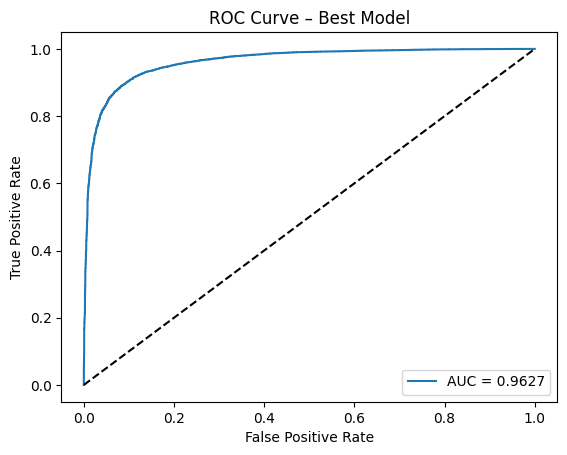

In [98]:
from sklearn.metrics import roc_curve, auc
best_model = models["tfidf_uni_bi_l2"]
best_proba = best_model.predict_proba(X_valid)[:, 1]

fpr, tpr, _ = roc_curve(y_valid, best_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.show()



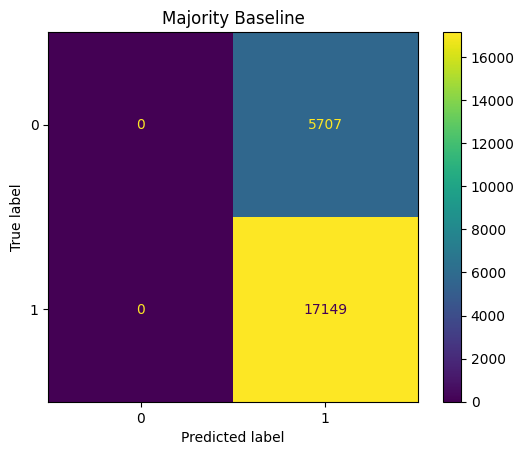

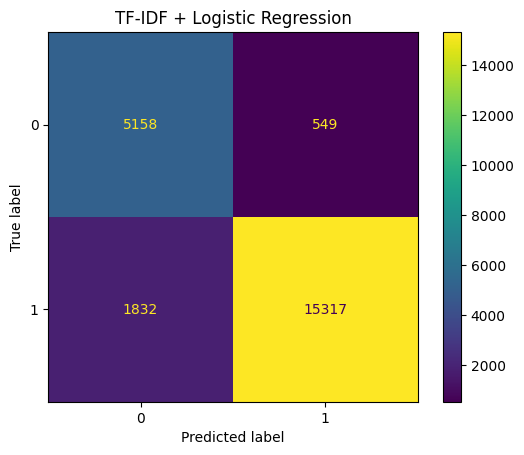

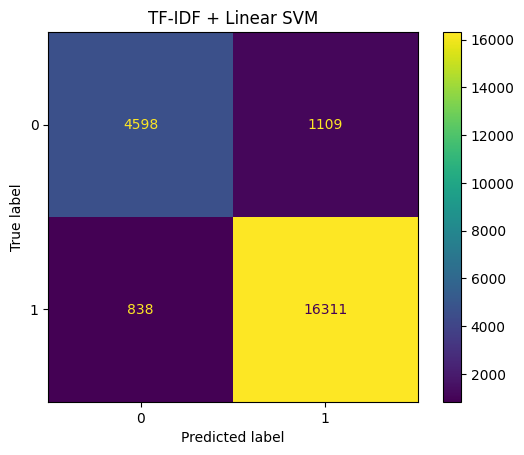

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

# Majority baseline
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    np.full_like(y_valid, majority_class)
)
plt.title("Majority Baseline")
plt.show()

# Logistic Regression (clf)
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_valid_pred
)
plt.title("TF-IDF + Logistic Regression")
plt.show()

# Linear SVM (svm_clf)
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_valid_pred_svm
)
plt.title("TF-IDF + Linear SVM")
plt.show()


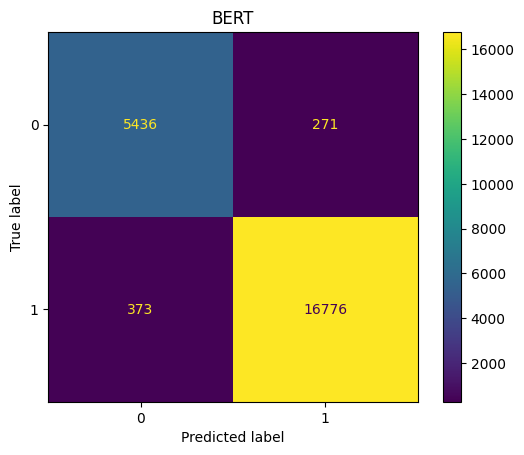

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_valid_bert
)
plt.title("BERT")
plt.show()

### 4. Baseline vs Model Performance

The majority-class baseline achieves ~75% accuracy, but this is misleading because it predicts 
the positive class for every example and completely fails to detect negatives (0% recall).

In contrast, the TF-IDF + Logistic Regression model achieves ~89% accuracy and an F1 of ~0.93, 
showing that even simple text features offer a substantial improvement. Linear SVM achieves 
similar performance, but bigram-enhanced Logistic Regression remains the strongest model overall.


,model,acc_test,prec_test,rec_test,f1_test,auc_test
2,TF-IDF (1–2-gram) + Linear SVM,0.914782,0.935192,0.952423,0.943729,NaN
5,tfidf_uni_bi_l2,0.902445,0.963471,0.904262,0.932928,0.960852
6,tfidf_uni_bi_l1,0.898989,0.963176,0.899773,0.930395,0.959228
1,TF-IDF (1–2-gram) + LogReg (saved model),0.894571,0.963000,0.893825,0.927124,0.957284
3,tfidf_uni_l2,0.876898,0.958080,0.874176,0.914207,0.945609
4,tfidf_uni_l1,0.876110,0.957681,0.873477,0.913643,0.945822
0,Majority baseline,0.750295,0.750295,1.000000,0.857336,0.500000


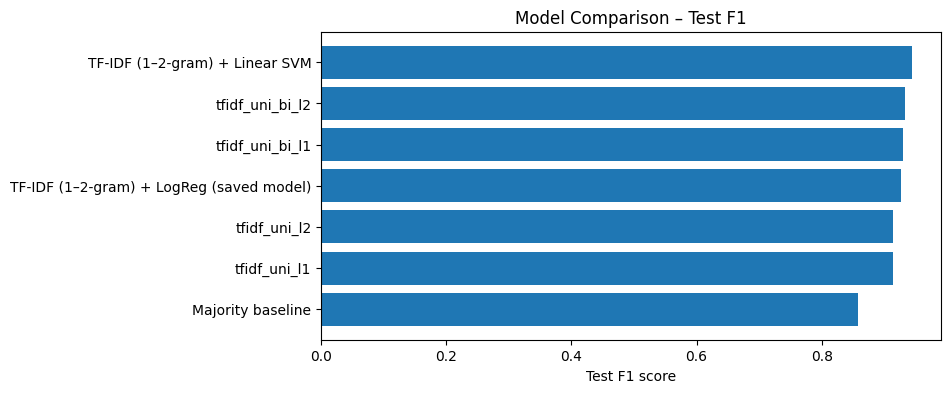

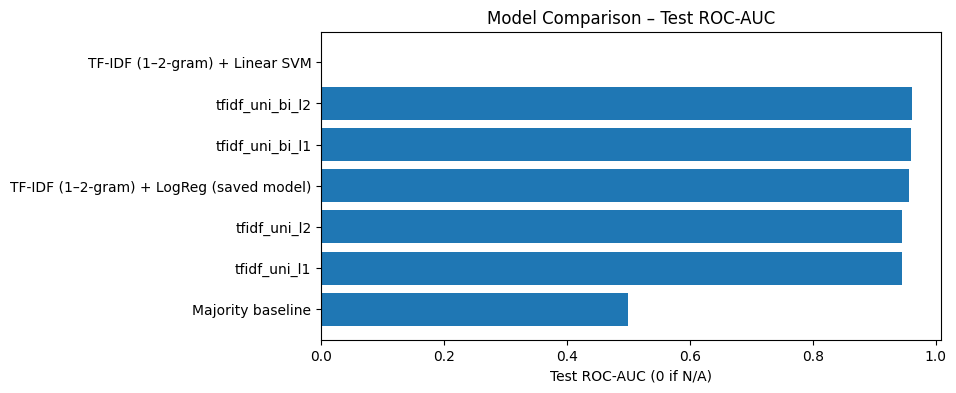

In [100]:
# 4. Baseline vs. Model Performance – comparison table

summary_rows = []

# Majority baseline (recompute for test set)
y_test_maj = np.full_like(y_test, majority_class)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_maj, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "Majority baseline",
        "acc_test": accuracy_score(y_test, y_test_maj),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": 0.5,  # random guess
    }
)

# Original TF-IDF + LogReg from earlier cells (clf / y_test_pred / y_test_proba)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "TF-IDF (1–2-gram) + LogReg (saved model)",
        "acc_test": accuracy_score(y_test, y_test_pred),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": roc_auc_score(y_test, y_test_proba),
    }
)

# Linear SVM (no probabilities, so no AUC)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred_svm, average="binary", zero_division=0
)
summary_rows.append(
    {
        "model": "TF-IDF (1–2-gram) + Linear SVM",
        "acc_test": accuracy_score(y_test, y_test_pred_svm),
        "prec_test": prec,
        "rec_test": rec,
        "f1_test": f1,
        "auc_test": np.nan,
    }
)

# Add the 4 extra TF-IDF + LogReg variants
summary_rows.extend(extra_results.to_dict(orient="records"))

results_df = pd.DataFrame(summary_rows)
results_df = results_df.sort_values("f1_test", ascending=False)

display(results_df)

# Simple visualization: F1 and AUC by model
plt.figure(figsize=(8, 4))
plt.barh(results_df["model"], results_df["f1_test"])
plt.xlabel("Test F1 score")
plt.title("Model Comparison – Test F1")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8, 4))
plt.barh(results_df["model"], results_df["auc_test"].fillna(0))
plt.xlabel("Test ROC-AUC (0 if N/A)")
plt.title("Model Comparison – Test ROC-AUC")
plt.gca().invert_yaxis()
plt.show()


In [101]:
# Grab the TF-IDF vectorizer from the fitted pipeline
vectorizer = clf.named_steps["tfidf"]

# Extract feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefs = clf.named_steps["clf"].coef_[0]   # coef of Logistic Regression

# Find top 20 positive and negative coefficients
top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]

top_pos_words = pd.DataFrame({
    "word": feature_names[top_pos_idx],
    "coef": coefs[top_pos_idx]
}).sort_values("coef", ascending=False)

top_neg_words = pd.DataFrame({
    "word": feature_names[top_neg_idx],
    "coef": coefs[top_neg_idx]
}).sort_values("coef", ascending=True)

print("Top positive words:")
display(top_pos_words)

print("\nTop negative words:")
display(top_neg_words)


Top positive words:


,word,coef
19,love,16.084057
18,perfect,15.429032
17,great,13.812125
16,amazing,13.149821
15,best,10.966516
14,excellent,10.190322
13,not too,9.683656
12,awesome,9.578153
11,beautiful,8.519058
10,wonderful,7.960798



Top negative words:


,word,coef
0,not,-12.869735
1,disappointed,-12.528352
2,horrible,-9.220261
3,broke,-8.913609
4,terrible,-8.245506
5,however,-8.216563
6,return,-8.148280
7,didn,-7.540068
8,worst,-7.520909
9,waste,-7.409773


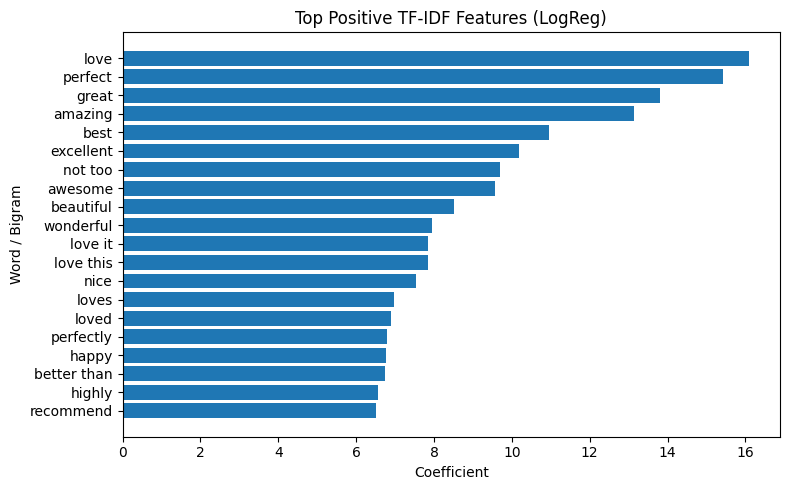

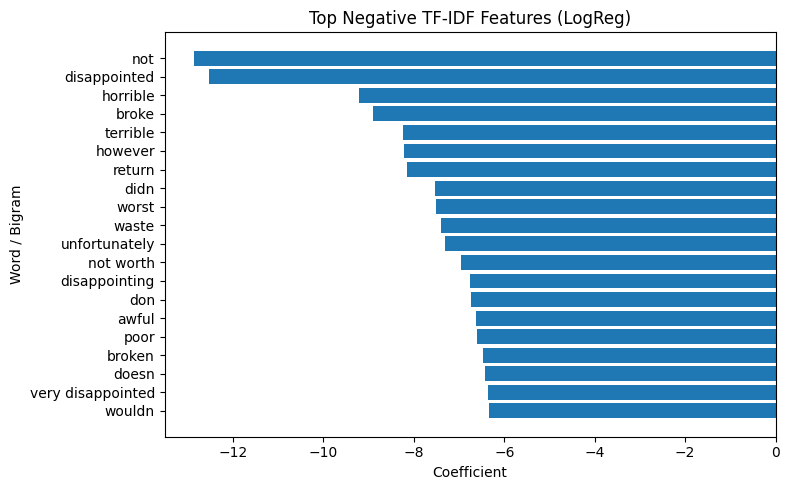

In [102]:
# Bar plot for top positive words
plt.figure(figsize=(8, 5))
plt.barh(top_pos_words["word"], top_pos_words["coef"])
plt.title("Top Positive TF-IDF Features (LogReg)")
plt.xlabel("Coefficient")
plt.ylabel("Word / Bigram")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

# Bar plot for top negative words
plt.figure(figsize=(8, 5))
plt.barh(top_neg_words["word"], top_neg_words["coef"])
plt.title("Top Negative TF-IDF Features (LogReg)")
plt.xlabel("Coefficient")
plt.ylabel("Word / Bigram")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


These coefficients confirm expected sentiment patterns. Strong positive weights correspond to 
clear approval terms (love, perfect, highly recommend), while negative coefficients 
indicate dissatisfaction (disappointed, worst, returning, doesn’t work). 

This interpretability is an advantage of linear models compared to transformer-based models.


## 5. Limitations and Future Work

**Limitations:**
- The dataset is skewed toward positive reviews (~75% positive), so even a naive baseline performs moderately well.
- TF–IDF ignores word order and long-range dependencies in text.
- We do not use additional metadata (price, brand, images), which could help disambiguate borderline cases.
- Some reviews may be sarcastic, ambiguous, or off-topic, which is challenging for simple text models.

**Potential improvements:**
- Use a transformer-based model (e.g., DistilBERT) fine-tuned on a subset of Beauty reviews.
- Incorporate review metadata (verified purchase, helpful votes) as extra features.
- Explore calibration techniques to better interpret predicted probabilities.
- Train per-subcategory models (e.g., skincare vs haircare) to capture more specific patterns.


## 6. Conclusion

We framed sentiment analysis for **Amazon Beauty & Personal Care** reviews as a binary classification problem.

- **Baseline:** A majority-class baseline achieves ~75% accuracy but fails to identify negative reviews.
- **Model:** A TF–IDF + Logistic Regression classifier substantially improves performance:
  - ~89% accuracy on the test set
  - ROC–AUC around 0.94
  - Much better balance between precision and recall for both classes

Despite its simplicity, text models performs strongly on large-scale review data and is computationally efficient and interpretable.